## Basic SVOL

Our model: https://mc-stan.org/docs/stan-users-guide/stochastic-volatility-models.html

In [211]:
import pandas as pd
import numpy as np
import pyjags
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark', {'axes.grid' : False})

## Sampling

In [212]:
# sampling configs
ITERS=20000
CHAINS=2
BURN_IN=0

In [213]:
''' 
  sample priors with asset return data using JAGS
  plot the distribution and chains
'''
def sample_n_plot(asset_returns, mean_log_vol, shock):
  
  # JAGS sampling
  jags_data = {"y": list(asset_returns), "N": len(asset_returns), "mlv": mean_log_vol, "s": shock}
  parameters = ['mu', 'phi', 'sigma']
  jags_model_string = '''
    model {
      mu ~ dnorm(0, 1/mlv)         # variance is inverse of the precision parameter
      phi ~ dunif(-1, 1)
      sigma ~ dnorm(0, 1/s) T(0,)

      h[1] ~ dnorm(mu, sqrt(1 - pow(phi, 2))/sigma )
      for (i in 2:N) {
        h[i] ~ dnorm(mu + phi * (h[i-1] - mu), 1/sigma)
      }
      
      for (j in 1:N) {
        y[j] ~ dnorm(0, 1/exp(h[j]/2) )
      }
    }
  '''
  jags_model = pyjags.Model(code=jags_model_string, data=jags_data, chains=CHAINS)
  jags_samples = jags_model.sample(iterations=ITERS, vars=parameters)

  # chains
  sample_chains = [jags_samples[p][0] for p in parameters]
  colors = ['teal', 'navy']
  
  
  ############### plots ##################
  
  fig, axs = plt.subplots(len(parameters), 2, figsize=(10, 8))
  axs[0, 0].set_title('Samples\' distribution')
  axs[0, 1].set_title('Sampling steps')
  
  for p in range(len(parameters)):
  
    for c in range(CHAINS):
      # samples' distribution
      sns.kdeplot(data=sample_chains[p][BURN_IN:, c], ax=axs[p, 0], color=colors[c], fill=True, alpha=0.7)
      # sampling steps
      sns.lineplot(data=sample_chains[p][BURN_IN:, c], ax=axs[p, 1], color=colors[c], alpha=0.7)
  
    # axs[p, 0].set_facecolor('black')
    axs[p, 0].set_ylabel(parameters[p])
    # axs[p, 1].set_facecolor('black')
  
  fig.suptitle(f'MCMC sampling with pyjags with {CHAINS} chains')
  plt.tight_layout()
  plt.show()

## Historical data
- Historical data of stock & cryptocurrency prices from [Investing.com](https://www.investing.com/)
- Data ranging from 01-01-2020 to 31-12-2022 i.e. price data of 3 years

In [214]:
# data

df = pd.read_csv('datasets/BAC22.csv')
print(df.shape)
df.head()

(756, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,33.12,33.10,33.30,32.86,28.20M,-0.06%
1,12/29/2022,33.14,32.89,33.16,32.75,22.25M,1.13%
2,12/28/2022,32.77,32.57,32.97,32.53,30.54M,0.74%
3,12/27/2022,32.53,32.50,32.67,32.28,22.78M,0.18%
4,12/23/2022,32.47,32.40,32.58,32.19,21.38M,0.25%


In [215]:
df.describe()

,Price,Open,High,Low
count,756.000000,756.000000,756.000000,756.000000
mean,34.624762,34.641283,35.072050,34.191548
std,7.564144,7.584706,7.592191,7.556052
min,18.080000,19.260000,19.670000,17.950000
25%,28.562500,28.667500,28.915000,28.130000
50%,34.790000,34.785000,35.070000,34.455000
75%,40.782500,40.672500,41.152500,40.252500
max,49.380000,49.910000,50.110000,49.030000


In [216]:
'''
  convert string to datetime
  change formats as required for the dates
  '%m/%d/%Y'
  '%b %d, %Y'
'''

df['Date'] = df['Date'].apply(lambda dt: datetime.strptime(dt, "%m/%d/%Y"))

In [217]:
# sorting data chronologically

df.sort_values(by='Date', inplace=True)
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
755,2020-01-02,35.64,35.35,35.66,35.29,37.64M,1.19%
754,2020-01-03,34.90,34.98,35.15,34.76,50.76M,-2.08%
753,2020-01-06,34.85,34.41,34.90,34.37,42.23M,-0.14%
752,2020-01-07,34.62,34.70,34.92,34.53,34.35M,-0.66%
751,2020-01-08,34.97,34.57,35.19,34.55,45.34M,1.01%
750,2020-01-09,35.03,35.30,35.33,34.94,39.88M,0.17%
749,2020-01-10,34.74,35.00,35.07,34.66,39.74M,-0.83%
748,2020-01-13,35.06,34.84,35.07,34.66,38.02M,0.92%
747,2020-01-14,35.32,35.30,35.67,35.11,66.79M,0.74%
746,2020-01-15,34.67,34.77,34.79,34.34,74.75M,-1.84%


In [218]:
# get asset returns from closing prices
# yt = 100 * (log(Pt) - log(Pt-1))
df['Asset_return'] = np.log(df['Price'].shift(-1) / df['Price']) * 100
df['Asset_return'] = df['Asset_return'].shift(1)

df[['Asset_return']].head()

,Asset_return
755,NaN
754,-2.098177
753,-0.143369
752,-0.662159
751,1.005900


In [219]:
# have asset returns mean-corrected

ar_mean = df[['Asset_return']].mean()
df['Asset_return'] = df['Asset_return'].apply(lambda a: a - ar_mean)

df[['Asset_return']].mean()

Asset_return   -6.117255e-17
dtype: float64

In [220]:
# asset returns, removing the first NaN
asset_returns_data = df[['Asset_return']].to_numpy().flatten()[1:]

In [221]:
# Initial priors

''' 
  Mean log volatility: mu
  -> take a normal distribution
  -> with mean -> 0 and variance -> variance of logarithmic returns
'''
mlv = np.mean(np.square(asset_returns_data))
print(f'Mean log volatility: {mlv}')

'''
  Persistence of volatility: phi
  -> uniform distribution between 0 to 1
  more complicated models available to estimate the persistence
'''

'''
  Shock scale distribution tends to be heavy-tailed in comparison to the swing in prices itself
  taking a wider normal distribtion
'''
shock_scale = mlv*2
print(f'Shock: {shock_scale}')


Mean log volatility: 6.7750821363304565
Shock: 13.550164272660913


adapting: iterations 2000 of 2000, elapsed 0:00:04, remaining 0:00:00
sampling: iterations 3978 of 40000, elapsed 0:00:08, remaining 0:01:12
sampling: iterations 9018 of 40000, elapsed 0:00:18, remaining 0:01:04
sampling: iterations 11454 of 40000, elapsed 0:00:25, remaining 0:01:02
sampling: iterations 13774 of 40000, elapsed 0:00:30, remaining 0:00:57
sampling: iterations 16082 of 40000, elapsed 0:00:35, remaining 0:00:53
sampling: iterations 18350 of 40000, elapsed 0:00:41, remaining 0:00:48
sampling: iterations 20610 of 40000, elapsed 0:00:46, remaining 0:00:43
sampling: iterations 25128 of 40000, elapsed 0:00:56, remaining 0:00:33
sampling: iterations 27374 of 40000, elapsed 0:01:01, remaining 0:00:28
sampling: iterations 31862 of 40000, elapsed 0:01:10, remaining 0:00:18
sampling: iterations 36430 of 40000, elapsed 0:01:18, remaining 0:00:08
sampling: iterations 40000 of 40000, elapsed 0:01:26, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:01:26, remaining 0:00

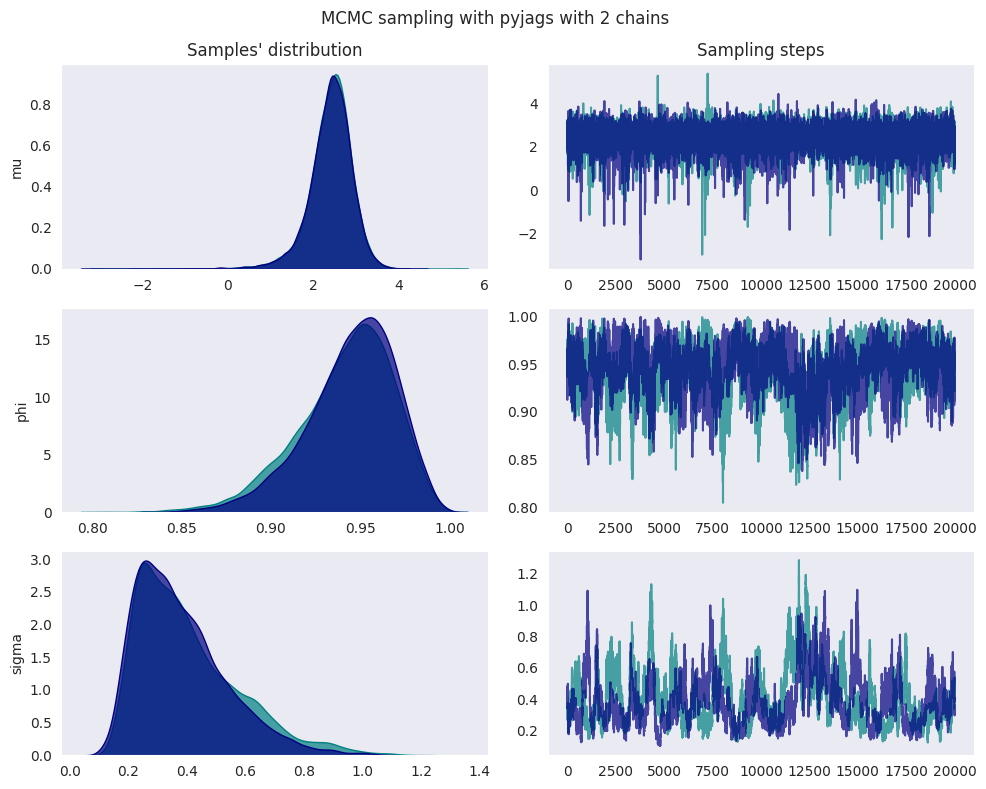

In [222]:
sample_n_plot(asset_returns=asset_returns_data, mean_log_vol=mlv, shock=shock_scale)

## Simulated data

In [223]:
# simulation configs
SAMPLE_SIZE=1000
MU=1
PHI=0.5
SIGMA=2

In [224]:
'''
  generate asset returns as per basic SVOL model
  params:
    n: number of asset returns to generate
  returns:
    returns n simulated asset_returns
'''
def generate_data(mu, phi, sigma, n=1):
  
  hs = [] # log volatilities
  ys = [] # asset returns

  # initial values
  h0 = np.random.normal( mu, np.sqrt(sigma/np.sqrt(1 - phi**2)) )
  hs.append(h0)
  ys.append( np.random.normal(0, np.exp(h0/2)) )

  for i in range(1, n):
    hs.append( np.random.normal( mu + phi*(hs[i-1] - mu), sigma) )
    ys.append( np.random.normal(0, np.exp(hs[i]/2)) )
  return ys


In [225]:
sim_asset_returns = generate_data(MU, PHI, SIGMA, SAMPLE_SIZE)

In [226]:
# Initial priors

''' 
  Mean log volatility: mu
  -> take a normal distribution
  -> with mean -> 0 and variance -> variance of logarithmic returns
'''
sim_mlv = np.mean(np.square(sim_asset_returns))
print(f'Mean log volatility: {sim_mlv}')

'''
  Persistence of volatility: phi
  -> uniform distribution between 0 to 1
  more complicated models available to estimate the persistence
'''

'''
  Shock scale distribution tends to be heavy-tailed in comparison to the swing in prices itself
  taking a wider normal distribtion
'''
sim_shock_scale = sim_mlv*2
print(f'Shock: {sim_shock_scale}')

Mean log volatility: 110.1655412721459
Shock: 220.3310825442918


adapting: iterations 2000 of 2000, elapsed 0:00:06, remaining 0:00:00
adapting: iterations 2000 of 2000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 3288 of 40000, elapsed 0:00:10, remaining 0:01:48
sampling: iterations 4982 of 40000, elapsed 0:00:16, remaining 0:01:50
sampling: iterations 6566 of 40000, elapsed 0:00:21, remaining 0:01:46
sampling: iterations 9726 of 40000, elapsed 0:00:30, remaining 0:01:35
sampling: iterations 11324 of 40000, elapsed 0:00:36, remaining 0:01:32
sampling: iterations 12888 of 40000, elapsed 0:00:42, remaining 0:01:28
sampling: iterations 15992 of 40000, elapsed 0:00:51, remaining 0:01:16
sampling: iterations 17564 of 40000, elapsed 0:00:56, remaining 0:01:12
sampling: iterations 20684 of 40000, elapsed 0:01:08, remaining 0:01:03
sampling: iterations 22210 of 40000, elapsed 0:01:13, remaining 0:00:59
sampling: iterations 23726 of 40000, elapsed 0:01:18, remaining 0:00:54
sampling: iterations 26754 of 40000, elapsed 0:01:28, remaining 0:00:44


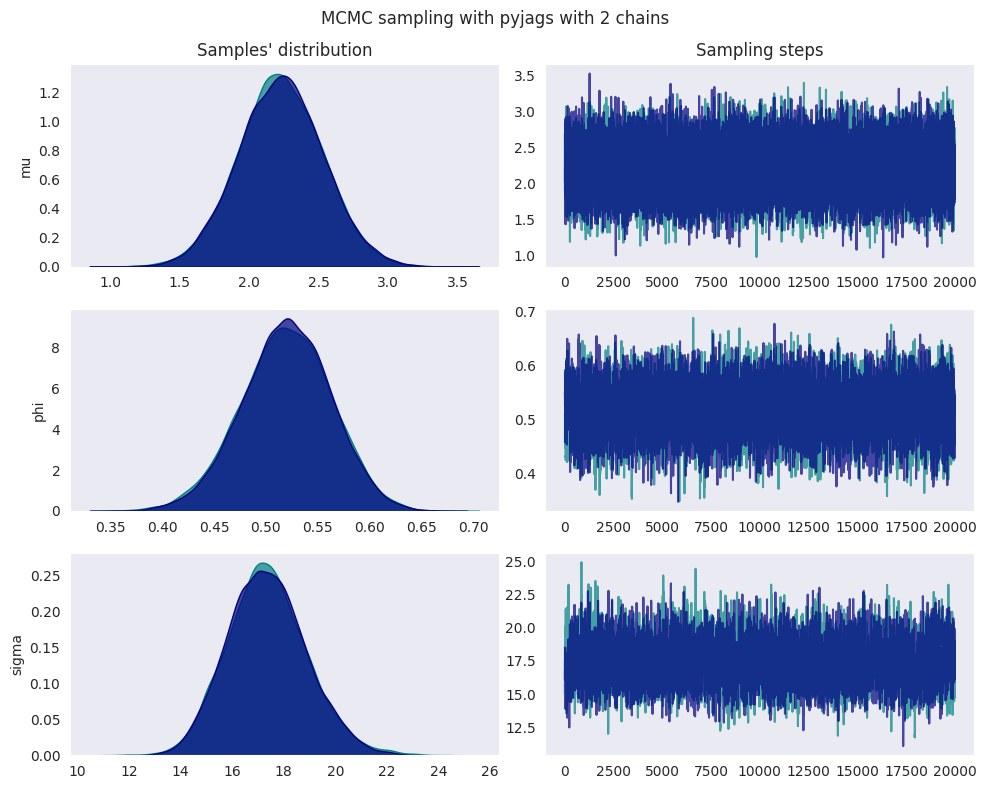

In [227]:
sample_n_plot(asset_returns=sim_asset_returns, mean_log_vol=sim_mlv, shock=sim_shock_scale)